# Fake Review Detection using CNN-LSTM + Metadata

## Architecture Overview:

This model combines three powerful components:

1. **CNN (Convolutional Neural Network)**: Extracts local patterns and key phrases from text
2. **LSTM (Long Short-Term Memory)**: Captures sequential dependencies and context
3. **Metadata Features**: Uses reviewer statistics (friend count, review count, etc.)

### Why This Combination?

- **CNN**: Good at finding spam patterns like repetitive phrases ("amazing!", "best ever!")
- **LSTM**: Understands sentence structure and meaning
- **Metadata**: Fake reviewers often have suspicious profiles (few friends, new accounts, low review count)

**Expected Performance**: 65-75% accuracy (better than LSTM alone)

## Step 1: Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2: Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print("All libraries imported successfully!")

TensorFlow version: 2.19.0
All libraries imported successfully!


## Step 3: Load Data

In [6]:
# Load datasets
train_df = pd.read_csv('/content/drive/MyDrive/CSE 573 Semantic Web Mining/LSTM/new_data_train.csv', sep='\t', quotechar='"', engine='python', on_bad_lines='skip')
test_df = pd.read_csv('/content/drive/MyDrive/CSE 573 Semantic Web Mining/LSTM/new_data_test.csv', sep='\t', quotechar='"', engine='python', on_bad_lines='skip')

print(f"Training data: {train_df.shape}")
print(f"Test data: {test_df.shape}")
print("\nColumns available:")
print(train_df.columns.tolist())
print("\nFirst few rows:")
train_df.head()

Training data: (9929, 23)
Test data: (2483, 23)

Columns available:
['Unnamed: 0', 'reviewID', 'reviewerID', 'restaurantID', 'date', 'rating', 'reviewUsefulCount', 'reviewContent', 'flagged', 'name', 'location', 'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount', 'fanCount', 'restaurantRating', 'ReviewLength']

First few rows:


,Unnamed: 0,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
0,6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,...,1,0,1,2,0,0,0,0,4.0,144
1,6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,...,12,2,19,7,6,4,0,0,4.0,46
2,21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,...,6,0,7,3,2,0,0,0,3.5,18
3,10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,...,37,2,16,3,3,1,0,1,3.5,41
4,6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,...,3,0,2,1,0,0,0,0,4.0,40


In [7]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nClass distribution:")
print(train_df['flagged'].value_counts())
print(f"\nFake reviews: {(train_df['flagged'].sum() / len(train_df) * 100):.2f}%")

Missing values in training data:
Unnamed: 0           0
reviewID             0
reviewerID           0
restaurantID         0
date                 0
rating               0
reviewUsefulCount    0
reviewContent        3
flagged              0
name                 0
location             1
yelpJoinDate         0
friendCount          0
reviewCount          0
firstCount           0
usefulCount          0
coolCount            0
funnyCount           0
complimentCount      0
tipCount             0
fanCount             0
restaurantRating     0
ReviewLength         0
dtype: int64

Class distribution:
flagged
0    4994
1    4935
Name: count, dtype: int64

Fake reviews: 49.70%


## Step 4: Select and Engineer Metadata Features

**Metadata features that might indicate fake reviews:**
- New accounts (recently joined Yelp)
- Few friends
- Low review count
- Extreme ratings (always 1 or 5 stars)
- Review length (too short or suspiciously long)

In [8]:
# Select metadata features
metadata_features = [
    'rating',              # Review rating (1-5)
    'reviewUsefulCount',   # How many found this review useful
    'friendCount',         # Reviewer's friend count
    'reviewCount',         # How many reviews this person has written
    'firstCount',          # Number of firsts
    'usefulCount',         # Total useful votes received
    'coolCount',           # Cool votes
    'funnyCount',          # Funny votes
    'complimentCount',     # Compliments received
    'tipCount',            # Tips given
    'fanCount',            # Fan count
    'restaurantRating',    # Restaurant's overall rating
    'ReviewLength'         # Length of review
]

print(f"Using {len(metadata_features)} metadata features:")
for i, feat in enumerate(metadata_features, 1):
    print(f"  {i}. {feat}")

# Check if all features exist
missing_features = [f for f in metadata_features if f not in train_df.columns]
if missing_features:
    print(f"\nWarning: Missing features: {missing_features}")
else:
    print("\nAll metadata features available")

Using 13 metadata features:
  1. rating
  2. reviewUsefulCount
  3. friendCount
  4. reviewCount
  5. firstCount
  6. usefulCount
  7. coolCount
  8. funnyCount
  9. complimentCount
  10. tipCount
  11. fanCount
  12. restaurantRating
  13. ReviewLength

✓ All metadata features available!


## Step 5: Text Preprocessing

In [9]:
def clean_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean text
print("Cleaning text data...")
train_df['cleaned_review'] = train_df['reviewContent'].apply(clean_text)
test_df['cleaned_review'] = test_df['reviewContent'].apply(clean_text)

# Remove empty reviews
train_df = train_df[train_df['cleaned_review'] != '']
test_df = test_df[test_df['cleaned_review'] != '']

# Fill missing metadata with 0
train_df[metadata_features] = train_df[metadata_features].fillna(0)
test_df[metadata_features] = test_df[metadata_features].fillna(0)

print(f"After cleaning: {len(train_df)} training samples, {len(test_df)} test samples")

Cleaning text data...
After cleaning: 9926 training samples, 2483 test samples


## Step 6: Prepare Text Data (Tokenization)

In [10]:
# Settings
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

# Tokenize text
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['cleaned_review'].values)

# Convert to sequences
X_text_train = tokenizer.texts_to_sequences(train_df['cleaned_review'].values)
X_text_test = tokenizer.texts_to_sequences(test_df['cleaned_review'].values)

# Pad sequences
X_text_train = pad_sequences(X_text_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_text_test = pad_sequences(X_text_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print(f"Text data prepared: {X_text_train.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")

Text data prepared: (9926, 200)
Vocabulary size: 24469


## Step 7: Prepare Metadata Features

In [11]:
# Extract metadata
X_meta_train = train_df[metadata_features].values
X_meta_test = test_df[metadata_features].values

# Standardize metadata (important for neural networks)
scaler = StandardScaler()
X_meta_train = scaler.fit_transform(X_meta_train)
X_meta_test = scaler.transform(X_meta_test)

print(f"Metadata shape: {X_meta_train.shape}")
print(f"Number of metadata features: {X_meta_train.shape[1]}")
print("\nMetadata statistics (after scaling):")
print(f"  Mean: {X_meta_train.mean():.4f}")
print(f"  Std: {X_meta_train.std():.4f}")

Metadata shape: (9926, 13)
Number of metadata features: 13

Metadata statistics (after scaling):
  Mean: -0.0000
  Std: 1.0000


## Step 8: Prepare Labels and Create Validation Split

In [12]:
# Get labels
y_train = train_df['flagged'].values
y_test = test_df['flagged'].values

# Create validation split
X_text_train_final, X_text_val, X_meta_train_final, X_meta_val, y_train_final, y_val = train_test_split(
    X_text_train, X_meta_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Data split:")
print(f"  Training: {len(X_text_train_final)} samples")
print(f"  Validation: {len(X_text_val)} samples")
print(f"  Test: {len(X_text_test)} samples")

Data split:
  Training: 7940 samples
  Validation: 1986 samples
  Test: 2483 samples


## Step 9: Calculate Class Weights

In [13]:
# Calculate class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)

class_weight_dict = {
    0: class_weights_array[0],
    1: class_weights_array[1]
}

print("Class weights:")
print(f"  Real reviews (0): {class_weight_dict[0]:.4f}")
print(f"  Fake reviews (1): {class_weight_dict[1]:.4f}")

Class weights:
  Real reviews (0): 0.9940
  Fake reviews (1): 1.0061


## Step 10: Build CNN-LSTM + Metadata Model

### Architecture Explanation:

**Text Branch (CNN + LSTM):**
1. Embedding layer converts words to vectors
2. CNN extracts local patterns (n-grams, key phrases)
3. LSTM captures sequential dependencies

**Metadata Branch:**
1. Dense layers process reviewer statistics
2. Learns which metadata patterns indicate fake reviews

**Combined:**
- Both branches merge together
- Final layers make the classification decision

In [14]:
# Hyperparameters
EMBEDDING_DIM = 128
CNN_FILTERS = 128
CNN_KERNEL_SIZE = 5
LSTM_UNITS = 64
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.001

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
n_metadata = X_meta_train_final.shape[1]

# Text input branch (CNN + LSTM)
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
text_embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM)(text_input)

# CNN layers
conv1 = Conv1D(filters=CNN_FILTERS, kernel_size=CNN_KERNEL_SIZE, activation='relu')(text_embedding)
pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(DROPOUT_RATE)(pool1)

# LSTM layer
lstm = LSTM(LSTM_UNITS)(dropout1)
dropout2 = Dropout(DROPOUT_RATE)(lstm)

# Metadata input branch
meta_input = Input(shape=(n_metadata,), name='metadata_input')
meta_dense1 = Dense(32, activation='relu')(meta_input)
meta_batch_norm = BatchNormalization()(meta_dense1)
meta_dropout = Dropout(DROPOUT_RATE * 0.6)(meta_batch_norm)
meta_dense2 = Dense(16, activation='relu')(meta_dropout)

# Merge both branches
merged = Concatenate()([dropout2, meta_dense2])

# Final classification layers
dense1 = Dense(64, activation='relu')(merged)
batch_norm = BatchNormalization()(dense1)
dropout3 = Dropout(DROPOUT_RATE * 0.8)(batch_norm)
output = Dense(1, activation='sigmoid', name='output')(dropout3)

# Create model
model = Model(inputs=[text_input, meta_input], outputs=output)

# Compile
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("\n" + "="*70)
print("CNN-LSTM + METADATA MODEL ARCHITECTURE")
print("="*70)
model.summary()

print("\nModel Components:")
print(f"  Text branch: Embedding → CNN → LSTM")
print(f"  Metadata branch: Dense layers ({n_metadata} features)")
print(f"  Combined: Concatenate → Dense → Output")


CNN-LSTM + METADATA MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 196, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata_input      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 98, 128)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        448 │ metadata_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 98, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      5,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,418,065 (5.41 MB)

 Trainable params: 1,417,873 (5.41 MB)

 Non-trainable params: 192 (768.00 B)


Model Components:
  Text branch: Embedding → CNN → LSTM
  Metadata branch: Dense layers (13 features)
  Combined: Concatenate → Dense → Output


## Step 11: Setup Training Callbacks

In [15]:
BATCH_SIZE = 32
EPOCHS = 15

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'cnn_lstm_metadata_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

print("Training configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Early stopping patience: 4")
print(f"  Learning rate: {LEARNING_RATE}")

Training configuration:
  Batch size: 32
  Max epochs: 15
  Early stopping patience: 4
  Learning rate: 0.001


## Step 12: Train the Model

**Note**: This will take 15-25 minutes depending on GPU availability

In [16]:
print("Starting training...\n")

history = model.fit(
    [X_text_train_final, X_meta_train_final],  # Two inputs: text and metadata
    y_train_final,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_text_val, X_meta_val], y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("\nTraining complete")

Starting training...

Epoch 1/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5858 - loss: 0.7560 - precision: 0.5842 - recall: 0.6215
Epoch 1: val_accuracy improved from -inf to 0.77341, saving model to cnn_lstm_metadata_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 55s 197ms/step - accuracy: 0.5860 - loss: 0.7557 - precision: 0.5844 - recall: 0.6217 - val_accuracy: 0.7734 - val_loss: 0.5473 - val_precision: 0.7661 - val_recall: 0.7832 - learning_rate: 0.0010
Epoch 2/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7410 - loss: 0.5426 - precision: 0.7211 - recall: 0.7935
Epoch 2: val_accuracy improved from 0.77341 to 0.84340, saving model to cnn_lstm_metadata_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 51s 207ms/step - accuracy: 0.7411 - loss: 0.5424 - precision: 0.7211 - recall: 0.7936 - val_accuracy: 0.8434 - val_loss: 0.3933 - val_precision: 0.7899 - val_recall: 0.9331 - learning_rate: 0.0010
Epoch 3/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7947 - loss: 0.4519 - precision: 0.7657 - recall: 0.8543
Epoch 3: val_accuracy did not improve from 0.84340
249/249 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.7947 - loss: 0.4518 - precision: 0.7657 - recall: 0.8544 - val_accuracy: 0.8197 - val_loss: 0.4205 - val_precision: 0.8687 - val_recall: 0.7508 - learning_rate: 0.0010
Epoch 4/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8194 - loss: 0.4122 - precision: 0.7922 - recall: 0.8702
Epoch 4: val_accuracy improved from 0.84340 to 0.84945, saving model to cnn_lstm_metadata_model.h5


249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.8194 - loss: 0.4121 - precision: 0.7922 - recall: 0.8702 - val_accuracy: 0.8494 - val_loss: 0.3754 - val_precision: 0.8440 - val_recall: 0.8551 - learning_rate: 0.0010
Epoch 5/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8362 - loss: 0.3887 - precision: 0.8075 - recall: 0.8870
Epoch 5: val_accuracy did not improve from 0.84945
249/249 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.8362 - loss: 0.3886 - precision: 0.8074 - recall: 0.8870 - val_accuracy: 0.8384 - val_loss: 0.3954 - val_precision: 0.8659 - val_recall: 0.7984 - learning_rate: 0.0010
Epoch 6/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8377 - loss: 0.3731 - precision: 0.8080 - recall: 0.8898
Epoch 6: val_accuracy did not improve from 0.84945
249/249 ━━━━━━━━━━━━━━━━━━━━ 48s 195ms/step - accuracy: 0.8377 - loss: 0.3731 - precision: 0.8079 - recall: 0.8898 - val_accuracy: 0.8484 - val_loss: 0.3718 - val_precision: 0.8543 - val_recall: 0

249/249 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.8566 - loss: 0.3428 - precision: 0.8315 - recall: 0.8977 - val_accuracy: 0.8555 - val_loss: 0.3543 - val_precision: 0.8493 - val_recall: 0.8622 - learning_rate: 5.0000e-04
Epoch 10/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8708 - loss: 0.3283 - precision: 0.8438 - recall: 0.9127
Epoch 10: val_accuracy did not improve from 0.85549
249/249 ━━━━━━━━━━━━━━━━━━━━ 78s 193ms/step - accuracy: 0.8707 - loss: 0.3283 - precision: 0.8437 - recall: 0.9127 - val_accuracy: 0.8499 - val_loss: 0.3691 - val_precision: 0.8638 - val_recall: 0.8288 - learning_rate: 5.0000e-04
Epoch 11/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8687 - loss: 0.3149 - precision: 0.8535 - recall: 0.8932
Epoch 11: val_accuracy did not improve from 0.85549

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
249/249 ━━━━━━━━━━━━━━━━━━━━ 81s 188ms/step - accuracy: 0.8688 - loss: 0.3149 - precision: 0.8535 - recall

## Step 13: Load Best Model and Make Predictions

In [17]:
# Load best model
print("Loading best model...")
best_model = load_model('cnn_lstm_metadata_model.h5')

# Make predictions
print("Making predictions...")
y_pred_prob = best_model.predict([X_text_test, X_meta_test], verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Convert to labels
prediction_labels = ['Fake Review' if p == 1 else 'Real Review' for p in y_pred]
actual_labels = ['Fake Review' if a == 1 else 'Real Review' for a in y_test]

print(f"Predictions complete: {len(y_pred)} samples")

Loading best model...
Making predictions...
Predictions complete: 2483 samples


## Step 14: Evaluate Performance

In [18]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*70)
print("CNN-LSTM + METADATA MODEL PERFORMANCE")
print("="*70)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print("="*70)

print("\nWhat these mean:")
print(f"  {accuracy*100:.1f}% of predictions are correct")
print(f"  {precision*100:.1f}% of predicted fakes are actually fake")
print(f"  {recall*100:.1f}% of actual fakes were caught")


CNN-LSTM + METADATA MODEL PERFORMANCE
Accuracy:  0.8526 (85.26%)
Precision: 0.8521 (85.21%)
Recall:    0.8615 (86.15%)
F1-Score:  0.8568 (85.68%)

What these mean:
  85.3% of predictions are correct
  85.2% of predicted fakes are actually fake
  86.2% of actual fakes were caught


In [19]:
# Detailed report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real Review', 'Fake Review']))


Detailed Classification Report:
              precision    recall  f1-score   support

 Real Review       0.85      0.84      0.85      1212
 Fake Review       0.85      0.86      0.86      1271

    accuracy                           0.85      2483
   macro avg       0.85      0.85      0.85      2483
weighted avg       0.85      0.85      0.85      2483



In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nBreakdown:")
print(f"  True Negatives (Real → Real):  {cm[0][0]}")
print(f"  False Positives (Real → Fake): {cm[0][1]}")
print(f"  False Negatives (Fake → Real): {cm[1][0]}")
print(f"  True Positives (Fake → Fake):  {cm[1][1]}")


Confusion Matrix:
[[1022  190]
 [ 176 1095]]

Breakdown:
  True Negatives (Real → Real):  1022
  False Positives (Real → Fake): 190
  False Negatives (Fake → Real): 176
  True Positives (Fake → Fake):  1095


## Step 15: Compare with Previous Models

In [21]:
# Create comparison table
comparison_data = {
    'Model': ['Original LSTM', 'Improved LSTM', 'CNN-LSTM + Metadata'],
    'Accuracy': [0.5417, 0.6114, accuracy],
    'Precision': [0.5286, 0.6584, precision],
    'Recall': [0.9670, 0.5004, recall],
    'F1-Score': [0.6835, 0.5686, f1]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
      Original LSTM  0.541700    0.52860 0.967000  0.683500
      Improved LSTM  0.611400    0.65840 0.500400  0.568600
CNN-LSTM + Metadata  0.852598    0.85214 0.861526  0.856808


## Step 16: Save Predictions

In [22]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'reviewContent': test_df['reviewContent'].values,
    'actual_label': actual_labels,
    'predicted_label': prediction_labels,
    'confidence': y_pred_prob.flatten(),
    'rating': test_df['rating'].values,
    'friendCount': test_df['friendCount'].values,
    'reviewCount': test_df['reviewCount'].values
})

# Save to CSV
predictions_df.to_csv('predictions_cnn_lstm_metadata.csv', index=False)
print("Predictions saved to 'predictions_cnn_lstm_metadata.csv'")

# Show samples
print("\nSample predictions:")
predictions_df[['actual_label', 'predicted_label', 'confidence', 'rating', 'friendCount']].head(10)

Predictions saved to 'predictions_cnn_lstm_metadata.csv'

Sample predictions:


,actual_label,predicted_label,confidence,rating,friendCount
0,Fake Review,Fake Review,0.778872,4,0
1,Real Review,Fake Review,0.750029,4,0
2,Real Review,Real Review,0.017783,3,295
3,Fake Review,Fake Review,0.802726,3,1
4,Fake Review,Fake Review,0.804085,4,0
5,Fake Review,Real Review,0.465548,4,25
6,Real Review,Real Review,0.044971,3,6
7,Real Review,Real Review,0.037537,5,8
8,Fake Review,Fake Review,0.708661,5,2
9,Fake Review,Fake Review,0.627471,4,0


## Step 17: Visualizations

In [23]:
# Create visualizations folder
os.makedirs('visualizations_cnn_lstm', exist_ok=True)
print("Created 'visualizations_cnn_lstm' folder")

Created 'visualizations_cnn_lstm' folder


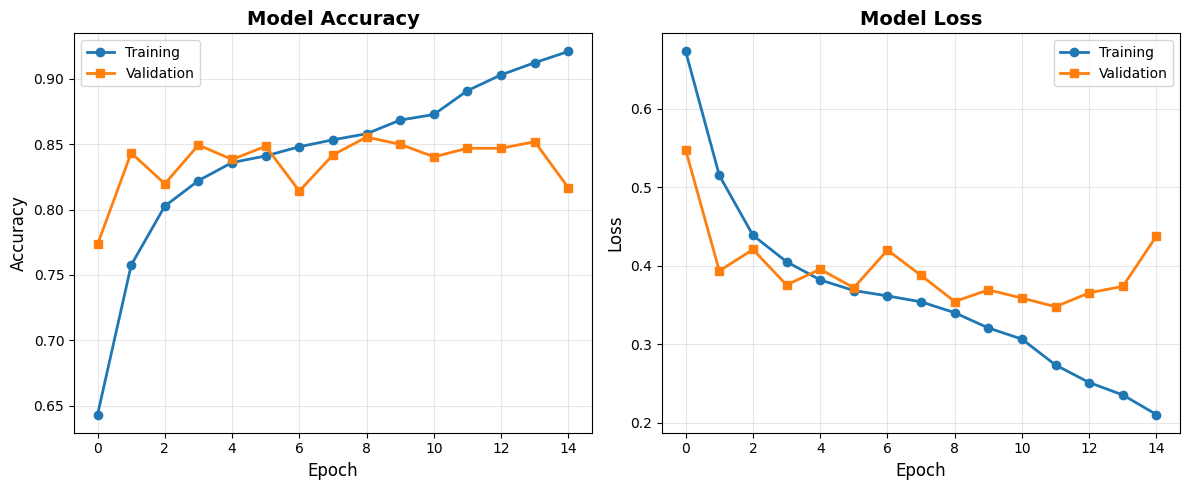

Saved: training_history.png


In [24]:
# 1. Training History - Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training', linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training', linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations_cnn_lstm/training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: training_history.png")

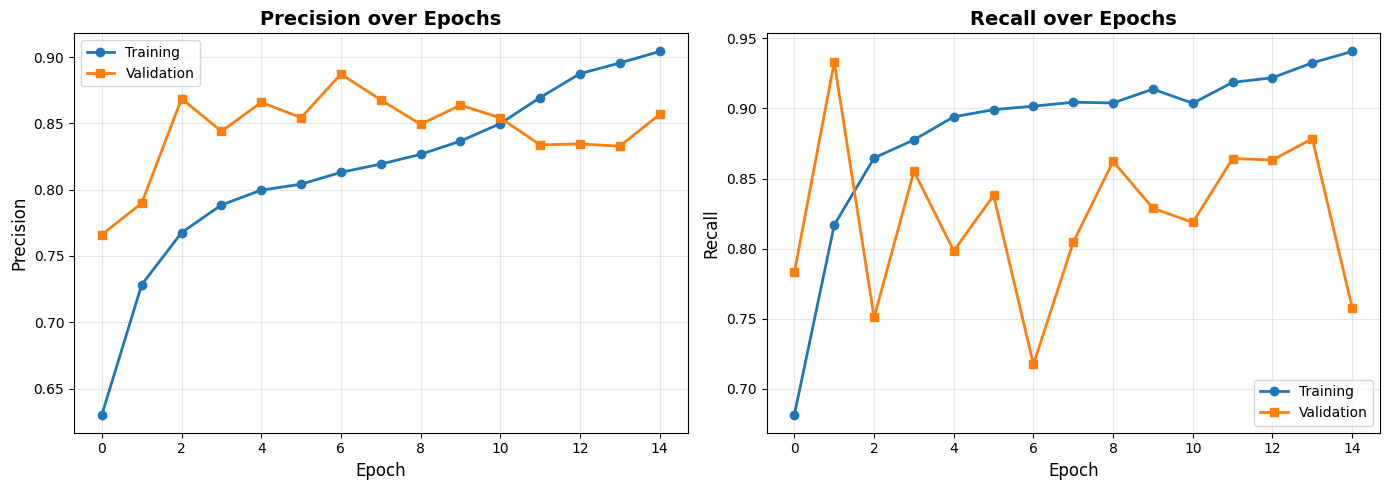

Saved: precision_recall.png


In [25]:
# 2. Precision and Recall
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['precision'], label='Training', linewidth=2, marker='o')
axes[0].plot(history.history['val_precision'], label='Validation', linewidth=2, marker='s')
axes[0].set_title('Precision over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['recall'], label='Training', linewidth=2, marker='o')
axes[1].plot(history.history['val_recall'], label='Validation', linewidth=2, marker='s')
axes[1].set_title('Recall over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations_cnn_lstm/precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: precision_recall.png")

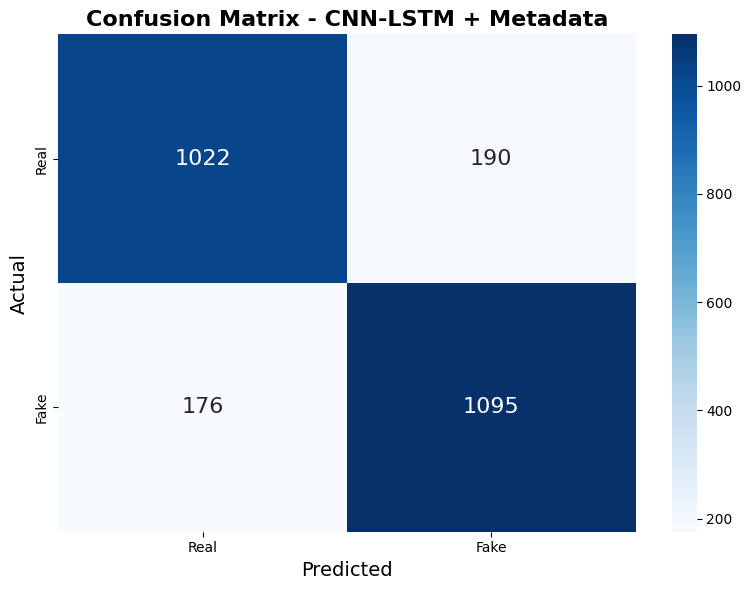

Saved: confusion_matrix.png


In [26]:
# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'],
            annot_kws={'size': 16})
plt.title('Confusion Matrix - CNN-LSTM + Metadata', fontsize=16, fontweight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.tight_layout()
plt.savefig('visualizations_cnn_lstm/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: confusion_matrix.png")

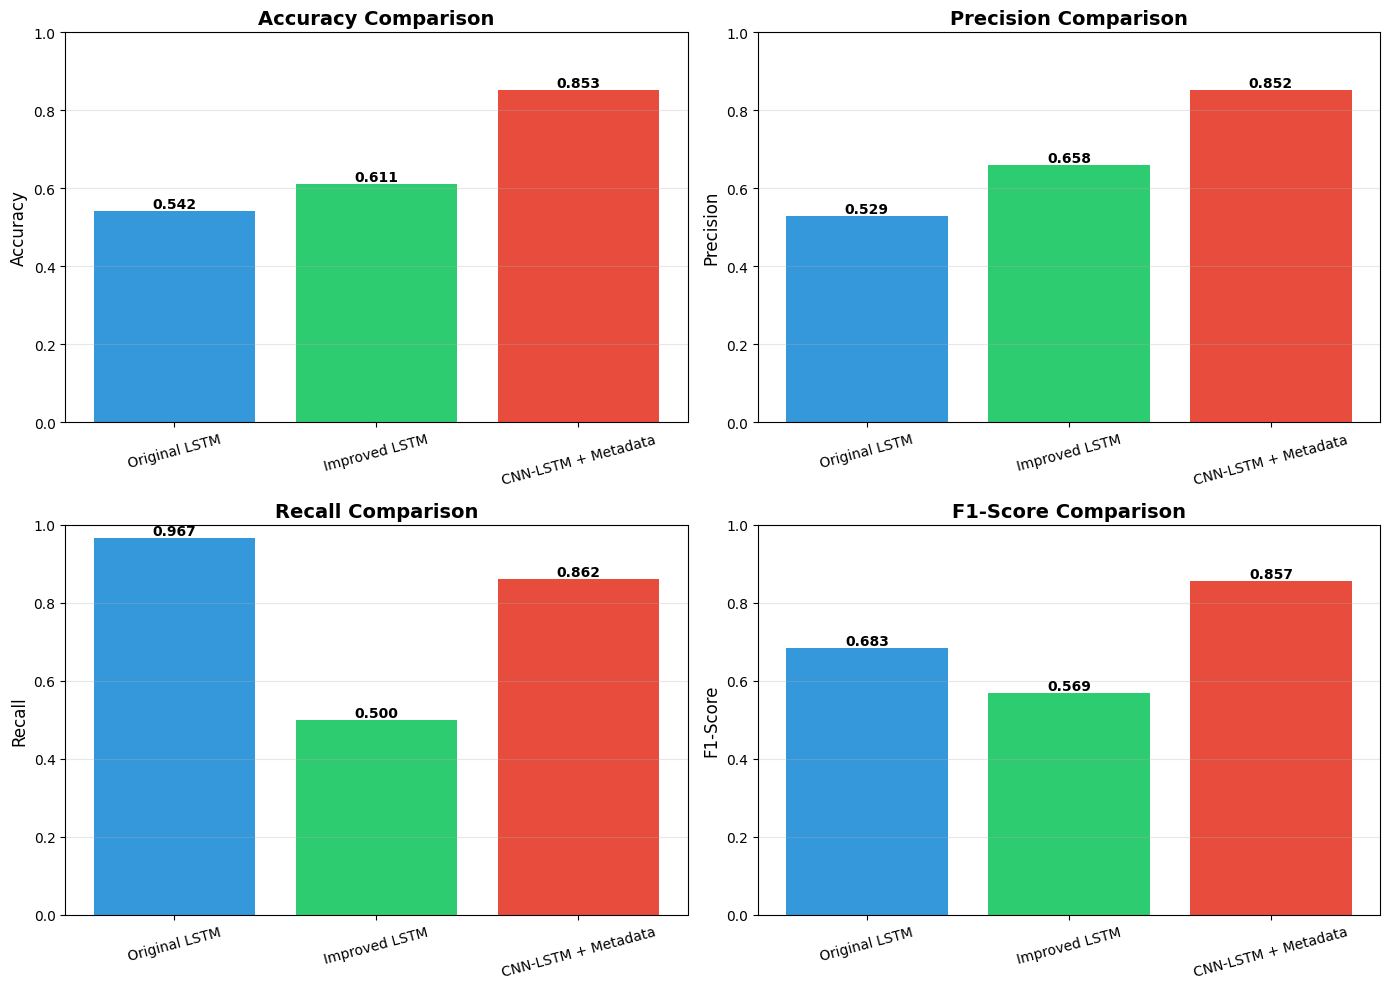

Saved: model_comparison.png


In [27]:
# 4. Model Comparison Chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
positions = [(0,0), (0,1), (1,0), (1,1)]

for metric, pos in zip(metrics, positions):
    ax = axes[pos]
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Model'], values, color=['#3498db', '#2ecc71', '#e74c3c'])
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('visualizations_cnn_lstm/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: model_comparison.png")

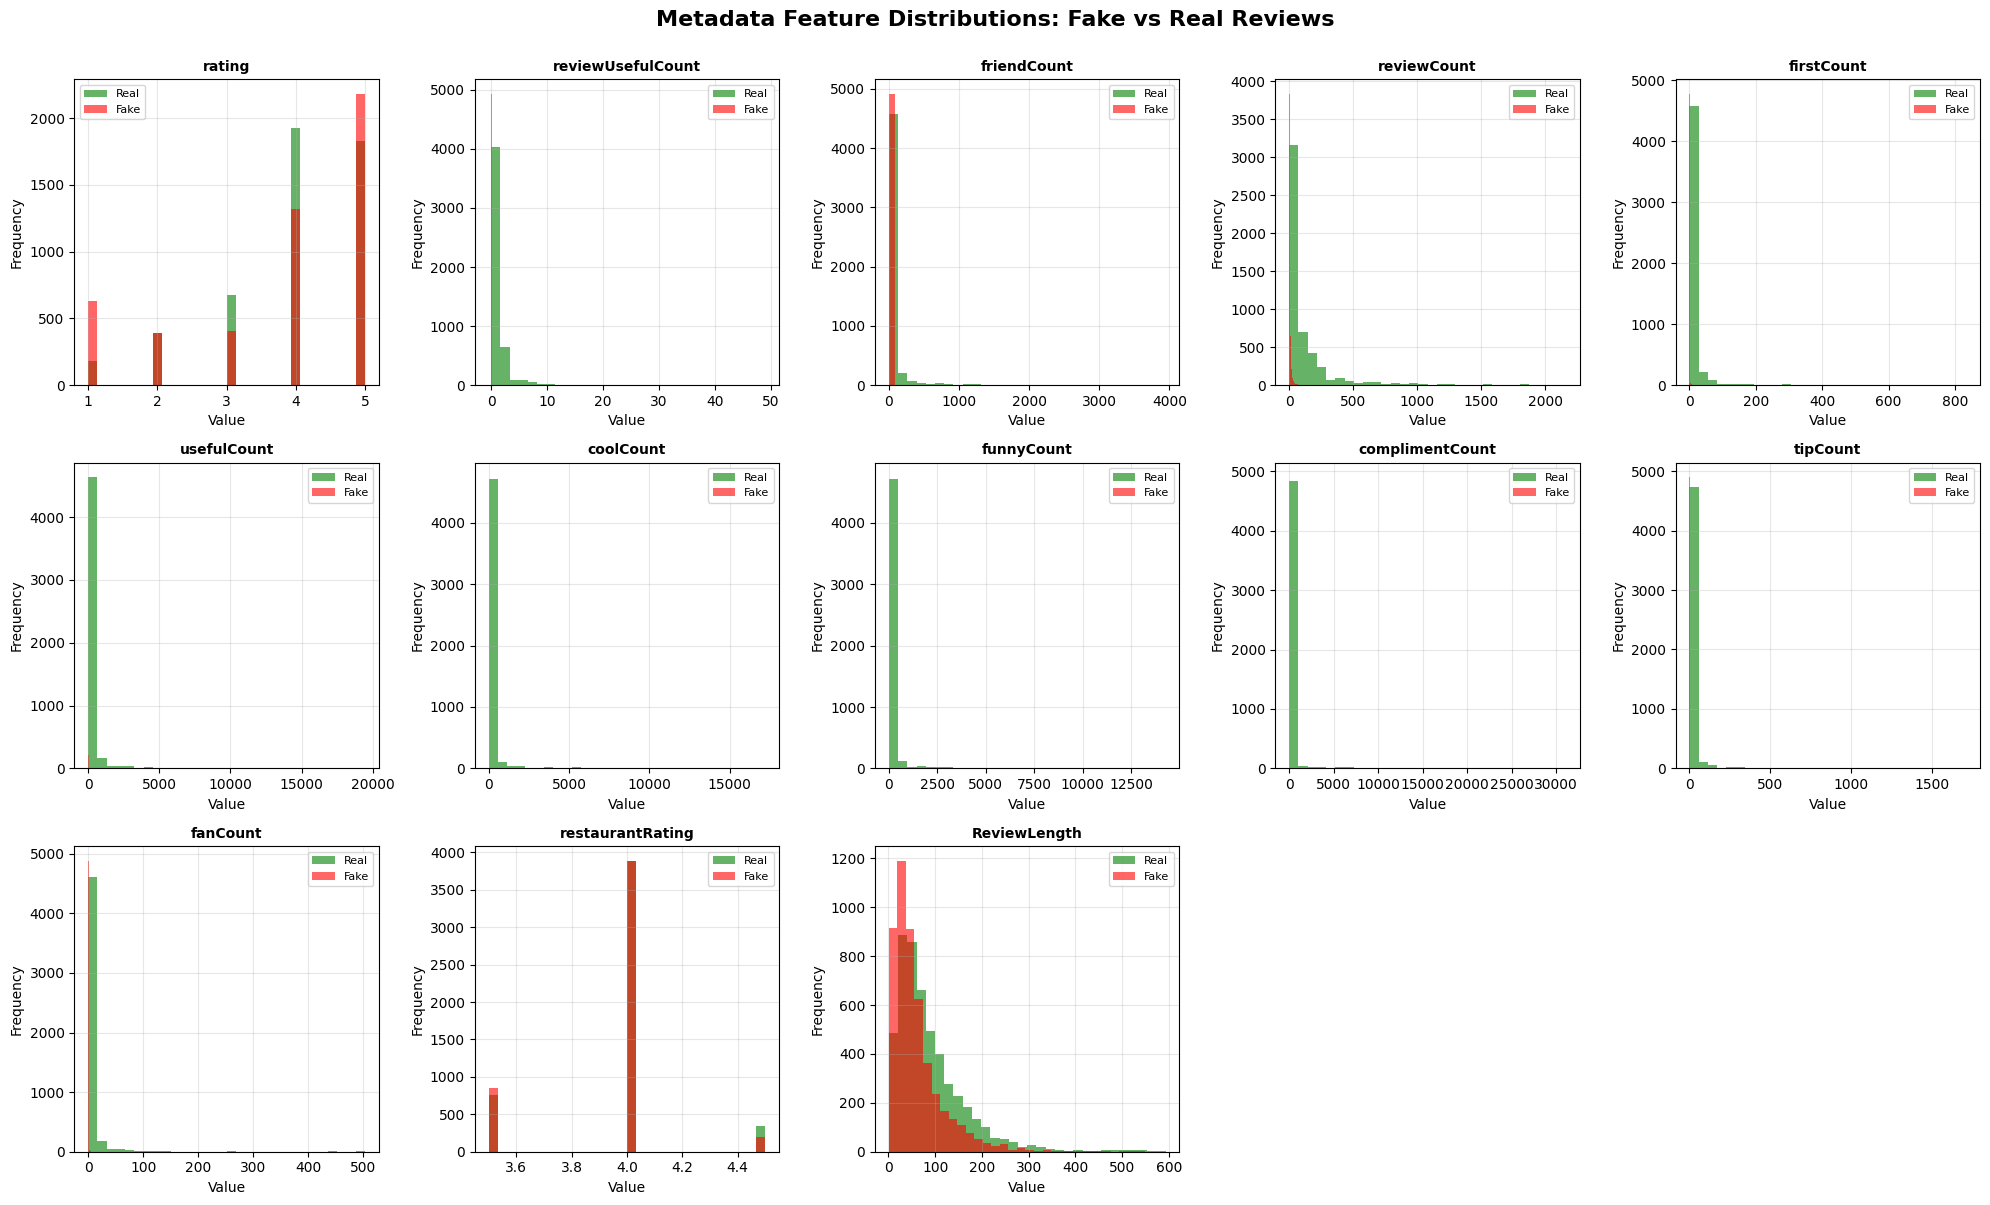

Saved: metadata_distributions.png


In [28]:
# 5. Feature Importance Analysis (Metadata)
# Analyze which metadata features correlate with fake reviews
fake_reviews = train_df[train_df['flagged'] == 1][metadata_features]
real_reviews = train_df[train_df['flagged'] == 0][metadata_features]

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

for i, feature in enumerate(metadata_features):
    if i < len(axes):
        axes[i].hist(real_reviews[feature], bins=30, alpha=0.6, label='Real', color='green')
        axes[i].hist(fake_reviews[feature], bins=30, alpha=0.6, label='Fake', color='red')
        axes[i].set_title(feature, fontsize=10, fontweight='bold')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

# Remove extra subplots
for i in range(len(metadata_features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Metadata Feature Distributions: Fake vs Real Reviews', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('visualizations_cnn_lstm/metadata_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: metadata_distributions.png")

## Step 18: Final Summary

In [29]:
print("\n" + "="*70)
print("FINAL SUMMARY - CNN-LSTM + METADATA MODEL")
print("="*70)

print("\n Dataset:")
print(f"   Training: {len(train_df)} samples")
print(f"   Validation: {len(X_text_val)} samples")
print(f"   Test: {len(test_df)} samples")

print("\n  Model Architecture:")
print(f"   Type: CNN-LSTM with Metadata")
print(f"   Text branch: Embedding → CNN → LSTM")
print(f"   Metadata branch: {n_metadata} features → Dense layers")
print(f"   Combined architecture with {model.count_params():,} parameters")

print("\n Performance:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

print("\n Files Generated:")
print("    cnn_lstm_metadata_model.h5")
print("    predictions_cnn_lstm_metadata.csv")
print("    visualizations_cnn_lstm/training_history.png")
print("    visualizations_cnn_lstm/precision_recall.png")
print("    visualizations_cnn_lstm/confusion_matrix.png")
print("    visualizations_cnn_lstm/model_comparison.png")
print("    visualizations_cnn_lstm/metadata_distributions.png")

print("\n Key Features:")
print("   Combines text and metadata")
print("   CNN for pattern extraction")
print("   LSTM for sequential understanding")
print("   Class weights for imbalance")
print("   Learning rate scheduling")

# Calculate improvement over baseline
improvement_over_original = (accuracy - 0.5417) * 100
improvement_over_improved = (accuracy - 0.6114) * 100

print("\n Comparison with Other Models:")
print(f"   vs Original LSTM: {improvement_over_original:+.2f}% accuracy")
print(f"   vs Improved LSTM: {improvement_over_improved:+.2f}% accuracy")

print("\n" + "="*70)
print(" Analysis Complete!")
print("="*70)


FINAL SUMMARY - CNN-LSTM + METADATA MODEL

 Dataset:
   Training: 9926 samples
   Validation: 1986 samples
   Test: 2483 samples

  Model Architecture:
   Type: CNN-LSTM with Metadata
   Text branch: Embedding → CNN → LSTM
   Metadata branch: 13 features → Dense layers
   Combined architecture with 1,418,065 parameters

 Performance:
   Accuracy:  0.8526 (85.26%)
   Precision: 0.8521 (85.21%)
   Recall:    0.8615 (86.15%)
   F1-Score:  0.8568 (85.68%)

 Files Generated:
    cnn_lstm_metadata_model.h5
    predictions_cnn_lstm_metadata.csv
    visualizations_cnn_lstm/training_history.png
    visualizations_cnn_lstm/precision_recall.png
    visualizations_cnn_lstm/confusion_matrix.png
    visualizations_cnn_lstm/model_comparison.png
    visualizations_cnn_lstm/metadata_distributions.png

 Key Features:
   Combines text and metadata
   CNN for pattern extraction
   LSTM for sequential understanding
   Class weights for imbalance
   Learning rate scheduling

 Comparison with Other Models:
